# Notebook: Introduction from Gaussian Processes to Bayesian Optimization

## Introduction 
As we know, Gaussian Process (GP) is one of the most popular models in the research region of machine learning because it is a non-parametric model and its also provides extra uncertainty. Moreover, GP is an excellent model for low-dimensional problems. Given those merits, Bayesian Optimization was proposed based on GP to solve expensive optimization problems. Within this notebook, we will guide through the basics and realizations from GP to BO. 
## 1. Kriging model
### 1.1 Basic of Kriging model (Noiseless case)
**Assume**

$$y = f(\mathrm{x}) = m(\mathrm{x}) + \epsilon$$
where $\epsilon \sim N(0, \sigma_e^2)$ and it's epistemic uncertainty, $m(\mathrm{x})$ is the mean function of observations, in this case set to be constant $\mu$

A Gaussian process if completely specified by its mean function and correlation function, which can be defined as:

$$m(\mathbf{x}) = \mathbb{E}\left [ f \left( \mathbf{x} \right) \right]$$
$$k(\mathbf{x}, \mathbf{x}') = \mathbb{E}\left [ (f (\mathbf{x}) - m(\mathbf{x}) )(f(\mathbf{x}') - m(\mathbf{x}'))\right]$$

Therefore, Gaussian process can be write as: 
$$f(\mathbf{x}) \sim  \mathcal{GP} (m(\mathrm{x}), k(\mathrm{x}, \mathrm{x}'))$$

**Kernel function**

A brief introduction to famous kernel function called **radial basis function**, **hyper-parameter estimation**, and **inference**.
**RBF kernel: spatial correlation**
    $$k(\mathrm{x}^{i}, \mathrm{x}^{j}) = exp\left(-\sum_{d=1}^{k} \theta_d \left({x}_{d}^{i}-{x}_{d}^{j}\right)^{p_d}\right)$$
    where $k$ is the dimension of the problem, $\mathrm{\theta}$  and $\mathrm{p}$ are two $k$-dimensional vectors of hyper-parameter
**Correlation matrix**
    $$\mathrm{K}(\mathrm{X,X}) = \begin{bmatrix}
    k(\mathrm{x}^{1}, \mathrm{x}^{1}) & ... & k(\mathrm{x}^{1}, \mathrm{x}^{n})\\
    ... & ... & ...\\
    k(\mathrm{x}^{n}, \mathrm{x}^{1})& ...& k(\mathrm{x}^{n}, \mathrm{x}^{n})
    \end{bmatrix}$$
    where $n$ is the number of samples

## 1.2 Negative Log Likelihood estimation for parameters
**Training by Negative Log Likelihood (NLL)**
    $$L = \frac{1}{\left(2\pi \sigma^2\right)|\mathbf{K}|^{\frac{1}{2}}}exp\left(-\frac{(\mathbf{y}-\mathbf{1}\mu)^T\mathbf{K}^{-1}(\mathbf{y}-\mathbf{1}\mu)}{2\sigma^2} \right)$$
**Take the natural logarithm (NLL):** 
    $$\ln(L) =-\frac{n}{2}\ln(2\pi) - \frac{n}{2}\ln(\sigma_e^2) - \frac{1}{2}\ln|\mathbf{K}|  -\frac{(\mathbf{y}-\mathbf{1}\mu)^T\mathbf{K}^{-1}(\mathbf{y}-\mathbf{1}\mu)}{2\sigma_e^2}$$
    in which, $2n+2$ parameters needed to be determined.

*First step: take derivative of NLL and set to be zero*
    $$\hat{\mu} = \frac{\mathbf{1}^T\mathbf{K}^{-1}\mathbf{y}}{\mathbf{1}^T\mathbf{K}^{-1}\mathbf{1}}, \,\, \hat{\sigma_e}^2 =\frac{(\mathbf{y}-\mathbf{1}\mu)^T\mathbf{K}^{-1}(\mathbf{y}-\mathbf{1}\mu)}{n} $$
*Second step: optimization for other parameters*
    $$\ln(L) = -\frac{n}{2} \ln(\hat{\sigma_e}^2) - \frac{1}{2} \ln |\mathbf{K}|$$


## 1.3 Inference

The prediction of the unseen points should be joint Gaussian with the observations. Therefore: 
$$ \begin{bmatrix}
    \mathbf{y} \\ \mathbf{y^{*}}
\end{bmatrix} \sim N \left( \begin{bmatrix}
    m(X) \\ m(X^*)
\end{bmatrix}, \begin{bmatrix}
    K(X,X) & K(X, X^*) \\ K(X^*, X) & K(X^*, X^*)
\end{bmatrix} \right)$$ 

**Predictive mean**
$$\mathbf{y^*} = m(X^*) +  K(X^*, X)K(X,X)^{-1}(\mathbf{y} - m(X)) $$

**Predictive variance: Epistemic uncertainty**
$$\mathbf{s^2}^* = \sigma_e^2\left(1-K\left( X^*, X\right )K\left(X,X\right)^{-1}K\left(X, X^*\right)  \right)  $$

## 1.4 Implementation of Kriging model 


In [1]:
# third party packages
import matplotlib.pyplot as plt
import numpy as np

# local funstions
from mfpml.models.sf_gpr import Kriging
from mfpml.problems.singlefidelity_functions import Forrester

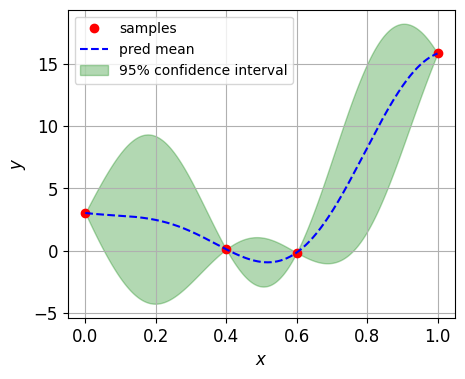

In [18]:
# define function
func = Forrester()

# initialize sampler

x = np.array([0.0, 0.4, 0.6, 1.0]).reshape((-1, 1))
test_x = np.linspace(0, 1, 1001, endpoint=True).reshape(-1, 1)

# get the function value
y = func.f(x)
test_y = func.f(test_x)

# train the model
model = Kriging(design_space=func._input_domain)
model.train(x, y)
sf_pre, sf_std = model.predict(test_x, return_std=True)

# plot the result
model.plot_prediction(figsize=(5, 4))

In [21]:
# to explore some important parameters
# estimated mean value
mu_estimated = model.mu
# sample mean value
sample_y_mean = np.mean(y)
print(f"mu_estimated:{mu_estimated:.4f}, sample_y_mean:{sample_y_mean:.4f}")

# estimated variance
sigma_estimated = model.sigma2
# sample variance
sample_y_var = np.var(y)
print(
    f"sigma_estimated:{sigma_estimated:.4f}, sample_y_var:{sample_y_var:.4f}")

# print the parameters
print(f"theta:{model.kernel.param}")
print(f"Kernel Matrix: \n {model.K}")

mu_estimated:6.0074, sample_y_mean:4.7056
sigma_estimated:41.5583, sample_y_var:42.8026
theta:[11.5654108]
Kernel Matrix: 
 [[1.00000000e+00 1.57163954e-01 1.55522822e-02 9.48868240e-06]
 [1.57163954e-01 1.00000000e+00 6.29634094e-01 1.55522822e-02]
 [1.55522822e-02 6.29634094e-01 1.00000000e+00 1.57163954e-01]
 [9.48868240e-06 1.55522822e-02 1.57163954e-01 1.00000000e+00]]


# 2 Gaussian Process (Noise case)

## 2.1 basics of Gaussian process 
The above mentioned Kriging model is a specific Gaussian Process model for handling deterministic functions/problems. While there are uncertainties within responses because of the data-collection manner like manufacturing, fabrication, and so on, and those uncertainties can not been eliminated even when the amount of data increasing. Therefore, this is called aleatoric uncertainty, also data uncertainty. 

<img src="figures/kriging.png" title="Noise responses problems" width="50%" align="right"> 

**Assumption**

The assumption of a Gaussian Process model for above needs to be changed, which can be expressed as:
 $$\mathbf{y} = f(\mathrm{x}) + noise$$

where noise usually is normal distributed with $ N\left(0, \sigma_a^2\right)$, and we usually refer it as data (aleatoric uncertainty). One has to mention that the first part of the above expression ($f(\mathrm{x})$) is can be learnt by Kriging model, and also the noise of can be regarded as white noise which is independent on the input $\mathrm{x}$. 

Therefore the mix-kernel Gaussian process is developed: 
- RBF kernel to learn $f(\mathrm{x})$
- white noise kernel to learn noise 

Noise subjects to $N\left(0, \sigma_a^2 \right)$, and noise is independently added to the outputs. Therefore, white noise kernel is proposed, which is defined by

$$k(\mathrm{x}, \mathrm{x}') = \sigma_a^2 \delta(\mathrm{x}, \mathrm{x}')$$

Intuitively, the white noise Correlation matrix is a diagonal matrix with 
diagonal elements $ \sigma_a^2$

## 2.2 Training, Inference of Gaussian Process
Simply to say, mix-kernel Gaussian process only changes its kernel combining two difference kernels compared with Kriging.

**Mix-kernel**

$$K_{mix}\left (\mathbf{X}, \mathbf{X} \right) =K_{RBF}\left (\mathbf{X}, \mathbf{X} \right)  + K_{noise}\left (\mathbf{X}, \mathbf{X} \right)  $$

**Training** 

Training process is same as Kriging model

**Inference** 

-Predictive mean 
        $$\mathbf{y^*} = m(X^*) +  K(X^*, X)K(X,X)^{-1}(\mathbf{y} - m(X)) $$

-Predicted variance
        $$\mathbf{s^2}^* = \sigma_e^2\left(1-K\left( X^*, X\right )K\left(X,X\right)^{-1}K\left(X, X^*\right)  \right) + \sigma_a^2 $$

## 2.3 Implementation

In [10]:
# import necessary functions from mfpml
from mfpml.models.sf_gpr import GaussianProcessRegressor
from mfpml.design_of_experiment.singlefideliy_samplers import LatinHyperCube

In [26]:
# sampling by sampling method
sampler = LatinHyperCube(design_space=func._design_space, seed=1)
sample_x = sampler.get_samples(num_samples=60)
test_x = np.linspace(0, 1, 101, endpoint=True).reshape(-1, 1)

# get samples by adding noise to the true function
sample_y = func.f(sample_x) + np.random.normal(0, 0.2,
                                               sample_x.shape[0]).reshape((-1, 1))
test_y = func.f(test_x) + np.random.normal(0, 0.2,
                                           test_x.shape[0]).reshape((-1, 1))
test_mean = func.f(test_x)

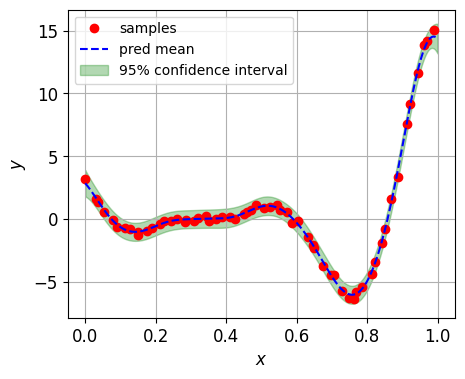

In [28]:

# initialize the regressor
gp = GaussianProcessRegressor(design_space=func._input_domain)
# train the model
gp.train(sample_x, sample_y)
# get the prediction
gp_pre, gp_std = gp.predict(test_x, return_std=True)

gp.plot_prediction(figsize=(5, 4))

In [31]:
# to explore some important parameters
# estimated mean value
mu_estimated = gp.mu
# sample mean value
sample_y_mean = np.mean(sample_y)
print(f"mu_estimated:{mu_estimated:.4f}, sample_y_mean:{sample_y_mean:.4f}")

# estimated variance
sigma_estimated = gp.sigma2
# sample variance
sample_y_var = np.var(sample_y)
print(
    f"sigma_estimated:{sigma_estimated:.4f}, sample_y_var:{sample_y_var:.4f}")

# print the parameters
print(f"theta:{gp.kernel.param}")
print(f"Kernel Matrix: \n {gp.K}")

# learned noise
print(f"noise:{gp.noise}")

mu_estimated:1.6614, sample_y_mean:0.4042
sigma_estimated:4.8295, sample_y_var:20.0518
theta:[95.04656313]
Kernel Matrix: 
 [[1.06271947e+00 1.21594730e-13 1.06685833e-08 ... 1.71205149e-09
  8.49798309e-04 6.60973686e-01]
 [1.21594730e-13 1.06271947e+00 2.55055316e-01 ... 3.97555247e-01
  2.62595693e-29 7.19873024e-17]
 [1.06685833e-08 2.55055316e-01 1.06271947e+00 ... 9.57479126e-01
  1.15381891e-21 2.84273646e-11]
 ...
 [1.71205149e-09 3.97555247e-01 9.57479126e-01 ... 1.06271947e+00
  6.11094776e-23 3.48853823e-12]
 [8.49798309e-04 2.62595693e-29 1.15381891e-21 ... 6.11094776e-23
  1.06271947e+00 1.72046647e-02]
 [6.60973686e-01 7.19873024e-17 2.84273646e-11 ... 3.48853823e-12
  1.72046647e-02 1.06271947e+00]]
noise:0.25043855463703135


In [32]:
# test noise
test_y = func.f(test_x)
test_y_mean = np.mean(test_y)
test_y_var = np.var(test_y)
print(f"test_y_mean:{test_y_mean:.4f}, test_y_var:{test_y_var:.4f}")

test_y_mean:0.5426, test_y_var:20.8635
